In [83]:
# %matplotlib inline
%pylab inline
import scipy
from pyiga import bspline, assemble, vform, geometry, vis, solvers
import numpy as np
import matplotlib.pyplot as plt

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\mechadmin\Documents\GitHub\pyiga\.venv\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['identity', 'grid', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


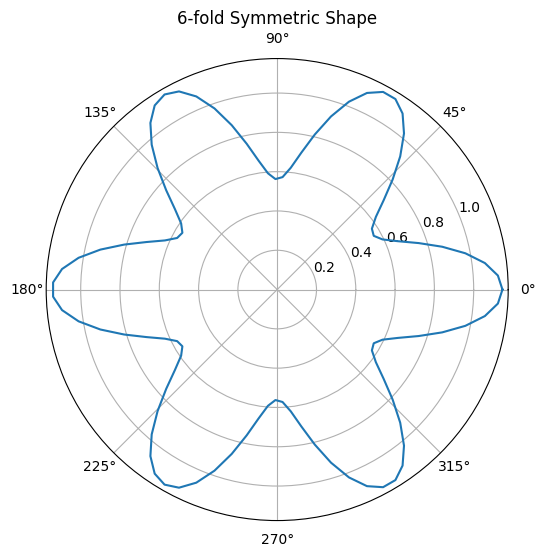

In [84]:
def cal_c(r, a, L0):
    return np.sqrt(2)*np.sqrt(np.pi*(3+3*r**2+2*r)*a*L0)/(np.pi*(3+3*r**2+2*r))
def superformula(theta, r, d, n, a, L0):
    c = cal_c(r,a,L0)
    return c*((1+r)-d*(-1)**((n+2)/2)*(r-1)*np.cos(n*theta))
d = 0.8
r = 0.4
n = 6
a = 0.1
L0 = 25
theta_values = np.linspace(0, 2 * np.pi, 100)
result = superformula(theta_values, r, d, n, a, L0)
# print(result)
plt.figure(figsize=(6, 6))
plt.polar(theta_values, result)
plt.title(f"{n}-fold Symmetric Shape")
plt.show()
def polar_to_cartesian(result, theta):
    x = result * np.cos(theta)
    y = result * np.sin(theta)
    return (x,y)
theta_values = np.linspace(0, 2 * np.pi, 100)
result = superformula(theta_values, r, d, n, a, L0)
# print(polar_to_cartesian(result, theta_values))

102
(102, 3)
(3, 3)


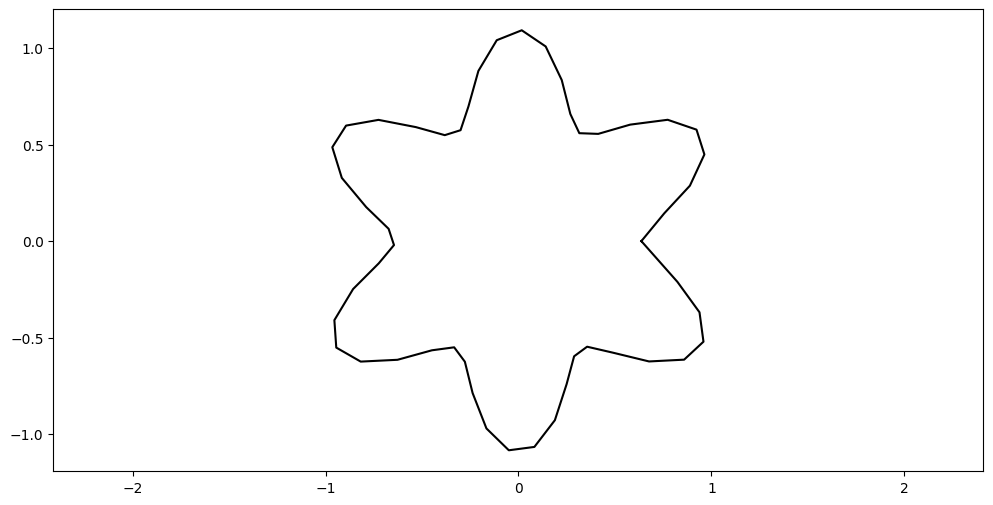

In [85]:
from pyiga.geometry import *
from pyiga import approx, bspline
kv = bspline.make_knots(3, 0.0, 1.0, 98)
# N = tuple(kv.numdofs for kv in kvs)
print(kv.numdofs)
r = 2.0
# construct quarter circle using NURBS
theta_values = np.linspace(0, 2 * np.pi, 102)
result = superformula(theta_values, r, d, n, a, L0)
coeff = np.array(polar_to_cartesian(result, theta_values))
w = np.ones((1,102))
coeff = np.vstack((coeff, w)).transpose()
print(coeff.shape)
coeffs = np.array([
        [  r, 1.0, 1.0],
        [  r,   r, 1.0 / np.sqrt(2.0)],
        [0.0,   r, 1.0]])
print(coeffs.shape)

grid = (np.linspace(0.0, 1.0, 2),)

nurbs = NurbsFunc((kv,), coeff.copy(), weights=None)
vals = nurbs.grid_eval(grid)
vis.plot_geo(nurbs, grid=grid,res=50, linewidth=None, color='black')
axis('equal');


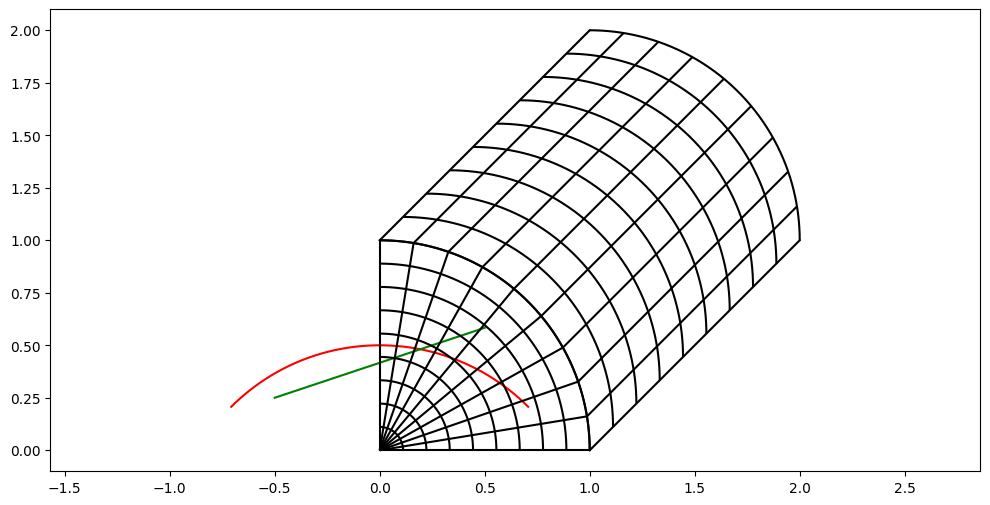

In [86]:
f = geometry.circular_arc(pi/2)
g = geometry.line_segment([0,0], [1,1])
vis.plot_geo(f.rotate_2d(pi/4).translate([0,-0.5]), color='red')
vis.plot_geo(g.scale([1,1/3]).translate([-.5,.25]), color='green')
axis('equal');
vis.plot_geo(geometry.outer_sum(f, g))
axis('equal');
vis.plot_geo(geometry.outer_product(f, g))
axis('equal');


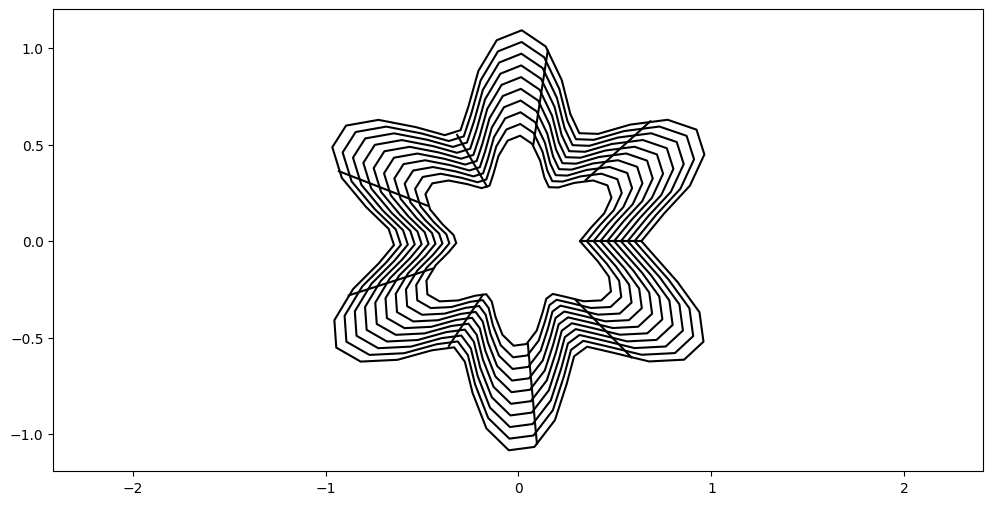

In [87]:
g = geometry.line_segment([0.5,0.5], [1,1])
geo = geometry.outer_product(nurbs, g)
vis.plot_geo(geo)
axis('equal');

In [88]:
# define geometry
# geo = geometry.quarter_annulus()

# define discretization space
p = 3     # spline degree
kvs = 2 * (bspline.make_knots(p, 0.0, 1.0, 50),)
kvs = 2*(bspline.make_knots(p, 0.0, 1.0, 98),)


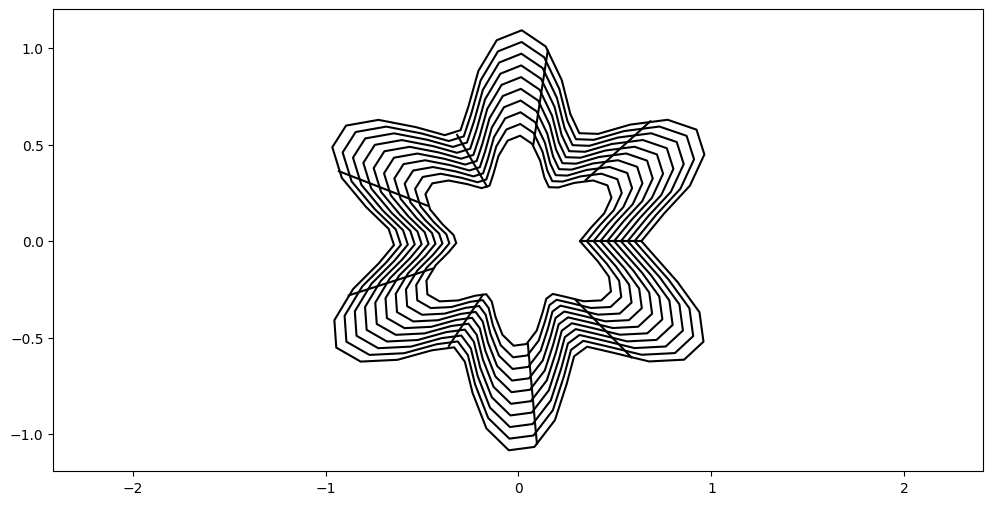

In [89]:
vis.plot_geo(geo)
axis('equal');

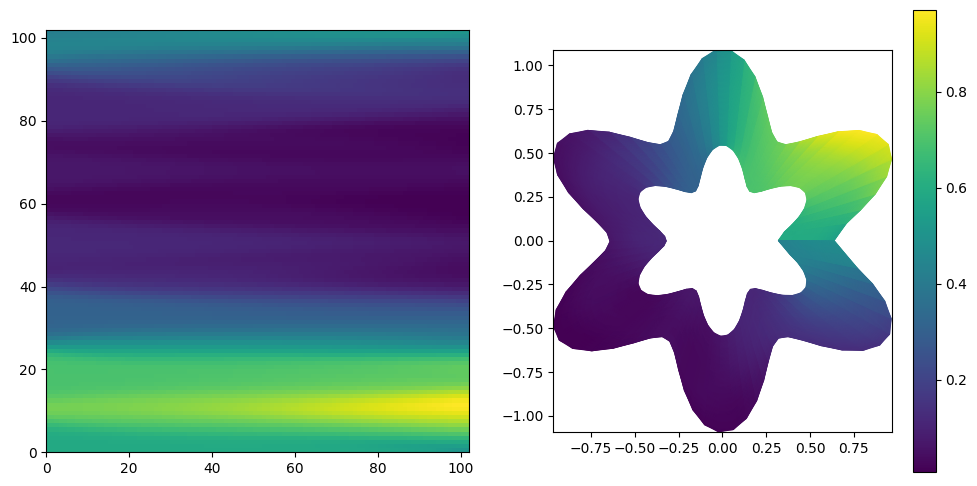

In [90]:
g = lambda x,y: np.exp(-(x-.8)**2 - (y-.8)**2)  # Dirichlet BC function
f = lambda x,y: 3 * np.sin(10*x) * np.cos(10*y) # source term

# compute Dirichlet boundary conditions
bcs = assemble.compute_dirichlet_bcs(kvs, geo, [('right', g), ('top', g)])

# compute right-hand side from function f
rhs = assemble.inner_products(kvs, f, f_physical=True, geo=geo).ravel()
# set up and solve linear system
A = assemble.stiffness(kvs, geo)
LS = assemble.RestrictedLinearSystem(A, rhs, bcs)

u = scipy.sparse.linalg.spsolve(LS.A, LS.b)
u_func = geometry.BSplineFunc(kvs, LS.complete(u))
# plot coefficients and solution
figsize(12,6)

subplot(1,2,1)
pcolormesh(u_func.coeffs)
gca().set_aspect('equal')

subplot(1,2,2)
vis.plot_field(u_func, geo)
gca().set_aspect('equal')
colorbar();

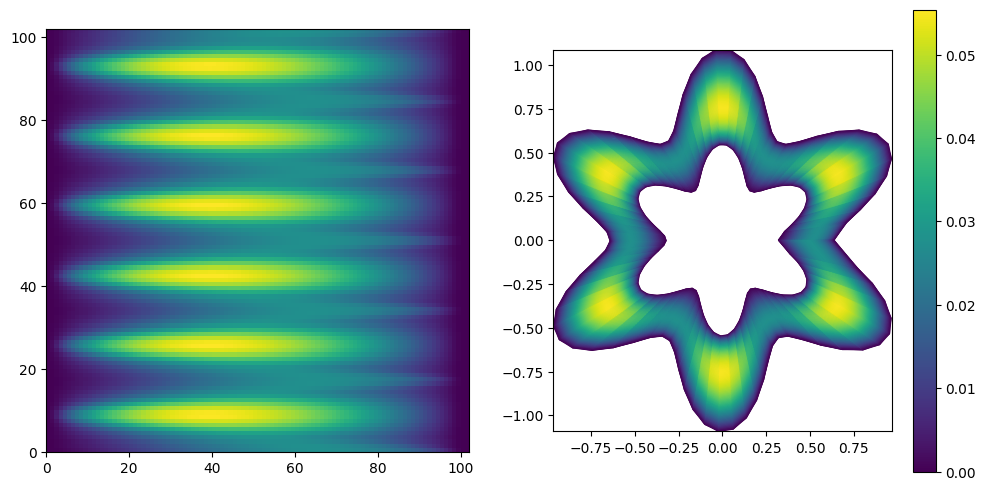

In [91]:
g = lambda x,y: 0  # Dirichlet BC function
f = lambda x,y: 3 # source term

# compute Dirichlet boundary conditions
bcs = assemble.compute_dirichlet_bcs(kvs, geo, [('left', g), ('right', g)])

# compute right-hand side from function f
rhs = assemble.inner_products(kvs, f, f_physical=True, geo=geo).ravel()
# set up and solve linear system
A = assemble.stiffness(kvs, geo)
LS = assemble.RestrictedLinearSystem(A, rhs, bcs)

u = scipy.sparse.linalg.spsolve(LS.A, LS.b)
u_func = geometry.BSplineFunc(kvs, LS.complete(u))
# plot coefficients and solution
figsize(12,6)

subplot(1,2,1)
pcolormesh(u_func.coeffs)
gca().set_aspect('equal')

subplot(1,2,2)
vis.plot_field(u_func, geo)
gca().set_aspect('equal')
colorbar();

In [94]:
matrix = rhs.reshape(102,102)
